In [15]:
# Run this cell FIRST and ALONE to suppress ALL deprecation warnings globally
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
print("Deprecation warnings suppressed. Proceed with other cells.")

Deprecation warnings suppressed. Proceed with other cells.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [16]:
# Install all necessary packages at once to avoid runtime issues
!pip install vaderSentiment gensim pyLDAvis python-louvain networkx matplotlib seaborn pandas numpy nltk scikit-learn

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 169, in _make_candidate_from_dist
    base = self._installed_candidate_cache[dist.canonical_name]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
KeyError: 'regex'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/u

In [17]:
# Suppress the annoying datetime.utcnow() warnings from Jupyter (harmless but noisy)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")

# Import libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import networkx as nx
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim import corpora, models
import pyLDAvis.gensim  # Updated for newer gensim versions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from google.colab import drive

In [18]:
# Mount Google Drive and load the dataset
drive.mount('/content/drive')
data_root = '/content/drive/My Drive/Vaccine Myths'

try:
    df = pd.read_csv(data_root + "/reddit_vm.csv")
    df = df[['title', 'score', 'id', 'url', 'comms_num', 'created', 'body', 'timestamp']]
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: CSV file not found. Check your drive path.")
    df = None
    exit()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully. Shape: (1602, 8)


In [19]:
# Download NLTK stopwords and define text cleaning function
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))  # Remove URLs
    text = re.sub(r'[^a-zA-Z ]', '', text)    # Remove non-alphabetic characters
    text = text.lower()                       # Lowercase
    return ' '.join([word for word in text.split() if word not in stops])  # Remove stopwords

if df is not None:
    df['cleaned'] = df['body'].astype(str).apply(clean_text)
    print("Text cleaning completed.")

Text cleaning completed.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Initialize sentiment analyzer and compute scores
sid = SentimentIntensityAnalyzer()
if df is not None:
    df['sentiment'] = df['cleaned'].apply(lambda x: sid.polarity_scores(x)['compound'])

    # Vectorized labeling for efficiency
    conditions = [
        (df['sentiment'] > 0.05),
        (df['sentiment'] < -0.05)
    ]
    choices = ['positive', 'negative']
    df['sentiment_label'] = np.select(conditions, choices, default='neutral')
    print("Sentiment analysis completed.")

Sentiment analysis completed.


/tmp/ipython-input-3086594982.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette='rocket_r')


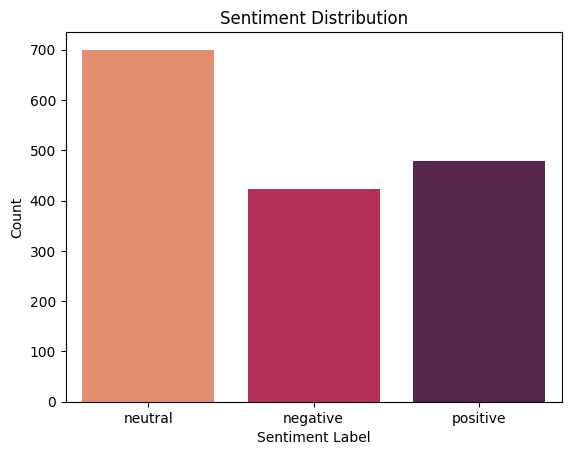

In [31]:
# Plot sentiment distribution
if df is not None:
    sns.countplot(data=df, x='sentiment_label', palette='rocket_r')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Count')
    plt.show()

In [22]:
# Prepare texts for LDA
if df is not None:
    texts = [text.split() for text in df['cleaned'] if text.strip()]  # Skip empty texts
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Train LDA model
    lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

    # Print topics
    topics = lda.print_topics(num_words=5)
    for i, topic in enumerate(topics):
        print(f"Topic {i+1}: {topic}")

Topic 1: (0, '0.014*"vaccine" + 0.010*"vaccines" + 0.009*"study" + 0.007*"dont" + 0.005*"one"')
Topic 2: (1, '0.069*"nan" + 0.009*"de" + 0.007*"measles" + 0.007*"que" + 0.006*"el"')
Topic 3: (2, '0.014*"vaccine" + 0.011*"vaccinated" + 0.009*"measles" + 0.006*"people" + 0.005*"pertussis"')
Topic 4: (3, '0.016*"vaccines" + 0.010*"dont" + 0.010*"people" + 0.008*"vaccine" + 0.008*"autism"')
Topic 5: (4, '0.018*"vaccine" + 0.008*"measles" + 0.007*"immunity" + 0.007*"vaccines" + 0.005*"like"')


In [28]:
# Prepare and display LDA visualization
if df is not None and 'lda' in locals() and 'corpus' in locals() and 'dictionary' in locals():
    try:
        pyLDAvis.enable_notebook()
        vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
        from IPython.display import display
        display(vis)  # Explicitly display the interactive visualization
        print("LDA visualization displayed successfully.")
    except Exception as e:
        print(f"Error displaying LDA visualization: {e}")
        print("Possible causes: Empty corpus/dictionary, version mismatch, or Colab rendering issues.")
else:
    print("LDA model, corpus, or dictionary not found. Ensure Cell 7 ran successfully.")

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.085525 -0.040421       1        1  33.190148
0      0.048220 -0.064610       2        1  26.067820
4      0.027525  0.020757       3        1  18.976755
2      0.019188  0.106233       4        1  12.013979
1     -0.180458 -0.021959       5        1   9.751299, topic_info=            Term        Freq       Total Category  logprob  loglift
0            nan  254.000000  254.000000  Default  30.0000  30.0000
392      measles  152.000000  152.000000  Default  29.0000  29.0000
2419          de   33.000000   33.000000  Default  28.0000  28.0000
375   vaccinated  146.000000  146.000000  Default  27.0000  27.0000
8        vaccine  444.000000  444.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
32           cdc    8.192538   56.141321   Topic5  -6.1076   0.4031
85          like    8.957784  182.210443   Topic5  -6.0183  -0.6849
403        cause    8.199976  103.780407   Topic5  -6.1067  -0.2104
117     immunity    7.506201   83.259632   Topic5  -6.1951  -0.0785
3            get    7.746631  159.947015   Topic5  -6.1636  -0.6998

[397 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6444      2  0.791538  accumulate
3456      3  0.919612    achieved
174       1  0.556080    actually
174       2  0.206913    actually
174       3  0.181049    actually
...     ...       ...         ...
29        1  0.540439       youre
29        2  0.265790       youre
29        3  0.115175       youre
29        4  0.026579       youre
29        5  0.053158       youre

[797 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

LDA visualization displayed successfully.


In [24]:
# Build TF-IDF similarity graph (only if dataset isn't too large to avoid memory issues)
if df is not None:
    tfidf = TfidfVectorizer(min_df=2).fit_transform(df['cleaned'])
    sim_matrix = linear_kernel(tfidf, tfidf)

    G = nx.Graph()
    threshold = 0.7  # Cosine similarity threshold
    max_edges = 10000  # Limit edges to prevent excessive computation
    edge_count = 0

    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if sim_matrix[i, j] > threshold:
                G.add_edge(df.loc[i, 'id'], df.loc[j, 'id'])
                edge_count += 1
                if edge_count >= max_edges:
                    print(f"Stopped at {max_edges} edges to avoid memory issues.")
                    break
        if edge_count >= max_edges:
            break

    print(f"Graph built. Number of nodes: {G.number_of_nodes()}, Number of edges: {G.number_of_edges()}")

Stopped at 10000 edges to avoid memory issues.
Graph built. Number of nodes: 391, Number of edges: 10000


Degree histogram: [0, 8, 5, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 137, 211, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

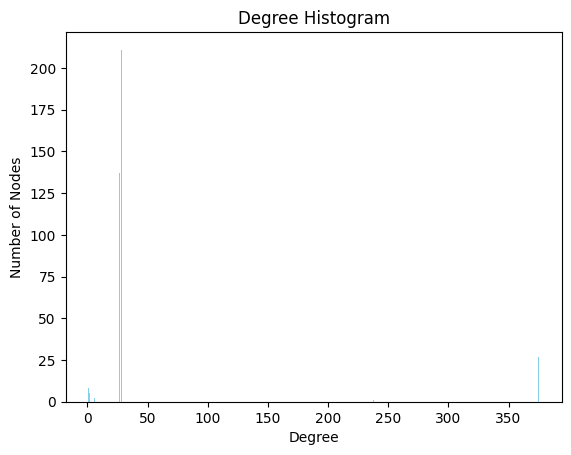

In [25]:
# Analyze graph degree distribution
if 'G' in locals() and G.number_of_nodes() > 0:
    degrees = [G.degree(n) for n in G.nodes()]

    # Print histogram data
    hist = nx.degree_histogram(G)
    print(f"Degree histogram: {hist}")

    # Plot degree histogram
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left', rwidth=0.8, color='skyblue')
    plt.title('Degree Histogram')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.show()
else:
    print("Graph is empty or not built.")

In [26]:
# Detect communities using Louvain method (with fallback)
if 'G' in locals() and G.number_of_nodes() > 0:
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G, random_state=42)
        print("Communities detected using Louvain.")
    except (ImportError, AttributeError):
        print("Louvain failed; using NetworkX greedy modularity as fallback.")
        from networkx.algorithms.community import greedy_modularity_communities
        communities = list(greedy_modularity_communities(G))
        partition = {}
        for idx, comm in enumerate(communities):
            for node in comm:
                partition[node] = idx

    # Map communities to DataFrame
    df['community'] = df['id'].map(partition).fillna(-1).astype(int)  # -1 for unmapped nodes

    # Analyze community sentiment
    community_sentiment = df.groupby('community')['sentiment'].mean().sort_values()
    print("Community sentiment averages:")
    print(community_sentiment)
else:
    print("No graph available for community detection.")

Louvain failed; using NetworkX greedy modularity as fallback.
Community sentiment averages:
community
 4   -0.077200
 0    0.000000
 6    0.000000
 1    0.000000
-1    0.017193
 5    0.264300
 3    0.391350
 2    0.421500
Name: sentiment, dtype: float64


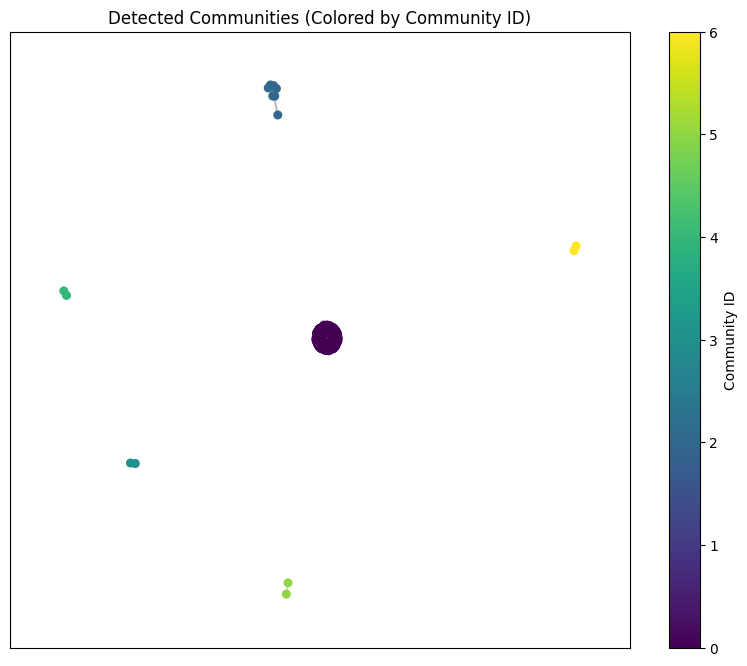

In [27]:
# Visualize the graph with communities
if 'G' in locals() and 'partition' in locals() and G.number_of_nodes() > 0:
    fig, ax = plt.subplots(figsize=(10, 8))  # Create figure and axes for proper colorbar support
    pos = nx.spring_layout(G, seed=42)
    cmap = plt.get_cmap('viridis')
    node_colors = [partition.get(n, 0) for n in G.nodes()]

    # Draw on the axes (ax) instead of directly on plt
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=30, node_color=node_colors, cmap=cmap)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.2)
    ax.set_title('Detected Communities (Colored by Community ID)')

    # Add colorbar to the axes
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])  # Required for colorbar
    cbar = plt.colorbar(sm, ax=ax, label='Community ID')
    plt.show()
else:
    print("No graph or communities to visualize.")